In [ ]:
#| default_exp models.nhits

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
# Initial
DATASET_NAME = 'BIDV'
DATASET_LABEL = 'BIDV'
TEST_RATIO = 0.1
TRAIN_TEST_LABEL = f'{(1 - TEST_RATIO) * 10:.0f}-{TEST_RATIO * 10:.0f}'

DAY_TO_PREDICT = 90

# NHITS with darts

## Install libraries

In [ ]:
%%capture
!pip install darts

In [ ]:
#| hide
import pandas as pd
import datetime
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from typing import List, Optional, Tuple, Union

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from darts import TimeSeries

from darts.logging import get_logger, raise_if_not
from darts.models.forecasting.pl_forecasting_module import (
    PLPastCovariatesModule,
    io_processor,
)
from darts.models.forecasting.torch_forecasting_model import PastCovariatesTorchModel
from darts.utils.torch import MonteCarloDropout

In [ ]:
logger = get_logger(__name__)

plt.rcParams['font.family'] = 'serif'
plt.rcParams["figure.figsize"] = (12,8)

COLORS = plt.get_cmap('tab10').colors

## N-HiTS model

In [ ]:
ACTIVATIONS = [
    "ReLU",
    "RReLU",
    "PReLU",
    "ELU",
    "Softplus",
    "Tanh",
    "SELU",
    "LeakyReLU",
    "Sigmoid",
    "GELU",
]

In [ ]:
class _Block(nn.Module):
    def __init__(
        self,
        input_chunk_length: int,
        output_chunk_length: int,
        num_layers: int,
        layer_width: int,
        nr_params: int,
        pooling_kernel_size: int,
        n_freq_downsample: int,
        batch_norm: bool,
        dropout: float,
        activation: str,
        MaxPool1d: bool,
    ):
        """PyTorch module implementing the basic building block of the N-HiTS architecture.

        The blocks produce outputs of size (target_length, nr_params); i.e.
        "one vector per parameter". The parameters are predicted only for forecast outputs.
        Backcast outputs are in the original "domain".

        Parameters
        ----------
        input_chunk_length
            The length of the input sequence fed to the model.
        output_chunk_length
            The length of the forecast of the model.
        num_layers
            The number of fully connected layers preceding the final forking layers.
        layer_width
            The number of neurons that make up each fully connected layer.
        nr_params
            The number of parameters of the likelihood (or 1 if no likelihood is used)
        pooling_kernel_size
            The kernel size for the initial pooling layer
        n_freq_downsample
            The factor by which to downsample time at the output (before interpolating)
        batch_norm
            Whether to use batch norm
        dropout
            Dropout probability
        activation
            The activation function of encoder/decoder intermediate layer.
        MaxPool1d
            Use MaxPool1d pooling. False uses AvgPool1d
        Inputs
        ------
        x of shape `(batch_size, input_chunk_length)`
            Tensor containing the input sequence.

        Outputs
        -------
        x_hat of shape `(batch_size, input_chunk_length)`
            Tensor containing the 'backcast' of the block, which represents an approximation of `x`
            given the constraints of the functional space determined by `g`.
        y_hat of shape `(batch_size, output_chunk_length)`
            Tensor containing the forward forecast of the block.

        """
        super().__init__()

        self.num_layers = num_layers
        self.layer_width = layer_width
        self.input_chunk_length = input_chunk_length
        self.output_chunk_length = output_chunk_length
        self.nr_params = nr_params
        self.pooling_kernel_size = pooling_kernel_size
        self.n_freq_downsample = n_freq_downsample
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.MaxPool1d = MaxPool1d

        raise_if_not(
            activation in ACTIVATIONS, f"'{activation}' is not in {ACTIVATIONS}"
        )
        self.activation = getattr(nn, activation)()

        # number of parameters theta for backcast and forecast
        """
        Note:
        -----
        We use two "last" layers, one for the backcast yielding n_theta_backcast outputs,
        and one for the forecast yielding n_theta_forecast outputs.

        In the original code, only one last layer yielding "input_chunk_length + n_theta_forecast" [1]
        outputs is used. So they don't use interpolation for the backcast [2], contrary to what is
        explained in the paper. Here we use what is explained in the paper.

        [1] https://github.com/cchallu/n-hits/blob/4e929ed31e1d3ff5169b4aa0d3762a0040abb8db/
        src/models/nhits/nhits.py#L263
        [2] https://github.com/cchallu/n-hits/blob/4e929ed31e1d3ff5169b4aa0d3762a0040abb8db/
        src/models/nhits/nhits.py#L66
        """
        n_theta_backcast = max(input_chunk_length // n_freq_downsample, 1)
        n_theta_forecast = max(output_chunk_length // n_freq_downsample, 1)

        # entry pooling layer
        pool1d = nn.MaxPool1d if self.MaxPool1d else nn.AvgPool1d
        self.pooling_layer = pool1d(
            kernel_size=self.pooling_kernel_size,
            stride=self.pooling_kernel_size,
            ceil_mode=True,
        )

        # layer widths
        in_len = int(np.ceil(input_chunk_length / pooling_kernel_size))
        self.layer_widths = [in_len] + [self.layer_width] * self.num_layers

        # FC layers
        layers = []
        for i in range(self.num_layers):
            layers.append(
                nn.Linear(
                    in_features=self.layer_widths[i],
                    out_features=self.layer_widths[i + 1],
                )
            )
            layers.append(self.activation)

            if self.batch_norm:
                layers.append(nn.BatchNorm1d(num_features=self.layer_widths[i + 1]))

            if self.dropout > 0:
                layers.append(MonteCarloDropout(p=self.dropout))

        self.layers = nn.Sequential(*layers)

        # Fully connected layer producing forecast/backcast expansion coefficients (waveform generator parameters).
        # The coefficients are emitted for each parameter of the likelihood for the forecast.
        self.backcast_linear_layer = nn.Linear(
            in_features=layer_width, out_features=n_theta_backcast
        )
        self.forecast_linear_layer = nn.Linear(
            in_features=layer_width, out_features=nr_params * n_theta_forecast
        )

    def forward(self, x):
        batch_size = x.shape[0]

        # pooling
        x = x.unsqueeze(1)
        x = self.pooling_layer(x)
        x = x.squeeze(1)

        # fully connected layer stack
        x = self.layers(x)

        # forked linear layers producing waveform generator parameters
        theta_backcast = self.backcast_linear_layer(x)
        theta_forecast = self.forecast_linear_layer(x)

        # set the expansion coefs in last dimension for the forecasts
        theta_forecast = theta_forecast.view(batch_size, self.nr_params, -1)

        # interpolate function expects (batch, "channels", time)
        theta_backcast = theta_backcast.unsqueeze(1)

        # interpolate both backcast and forecast from the thetas
        x_hat = F.interpolate(
            theta_backcast, size=self.input_chunk_length, mode="linear"
        )
        y_hat = F.interpolate(
            theta_forecast, size=self.output_chunk_length, mode="linear"
        )

        x_hat = x_hat.squeeze(1)  # remove 2nd dim we added before interpolation

        # Set the distribution parameters as the last dimension
        y_hat = y_hat.reshape(x.shape[0], self.output_chunk_length, self.nr_params)

        return x_hat, y_hat

In [ ]:
class _Stack(nn.Module):
    def __init__(
        self,
        input_chunk_length: int,
        output_chunk_length: int,
        num_blocks: int,
        num_layers: int,
        layer_width: int,
        nr_params: int,
        pooling_kernel_sizes: Tuple[int],
        n_freq_downsample: Tuple[int],
        batch_norm: bool,
        dropout: float,
        activation: str,
        MaxPool1d: bool,
    ):
        """PyTorch module implementing one stack of the N-BEATS architecture that comprises multiple basic blocks.

        Parameters
        ----------
        input_chunk_length
            The length of the input sequence fed to the model.
        output_chunk_length
            The length of the forecast of the model.
        num_blocks
            The number of blocks making up this stack.
        num_layers
            The number of fully connected layers preceding the final forking layers in each block.
        layer_width
            The number of neurons that make up each fully connected layer in each block.
        nr_params
            The number of parameters of the likelihood (or 1 if no likelihood is used)
        pooling_kernel_sizes
            sizes of pooling kernels for every block in this stack
        n_freq_downsample
            downsampling factors to apply for block in this stack
        batch_norm
            whether to apply batch norm on first block of this stack
        dropout
            Dropout probability
        activation
            The activation function of encoder/decoder intermediate layer.
        MaxPool1d
            Use MaxPool1d pooling. False uses AvgPool1d

        Inputs
        ------
        stack_input of shape `(batch_size, input_chunk_length)`
            Tensor containing the input sequence.

        Outputs
        -------
        stack_residual of shape `(batch_size, input_chunk_length)`
            Tensor containing the 'backcast' of the block, which represents an approximation of `x`
            given the constraints of the functional space determined by `g`.
        stack_forecast of shape `(batch_size, output_chunk_length)`
            Tensor containing the forward forecast of the stack.

        """
        super().__init__()

        self.input_chunk_length = input_chunk_length
        self.output_chunk_length = output_chunk_length
        self.nr_params = nr_params

        # TODO: leave option to share weights across blocks?
        self.blocks_list = [
            _Block(
                input_chunk_length,
                output_chunk_length,
                num_layers,
                layer_width,
                nr_params,
                pooling_kernel_sizes[i],
                n_freq_downsample[i],
                batch_norm=(
                    batch_norm and i == 0
                ),  # batch norm only on first block of first stack
                dropout=dropout,
                activation=activation,
                MaxPool1d=MaxPool1d,
            )
            for i in range(num_blocks)
        ]
        self.blocks = nn.ModuleList(self.blocks_list)

    def forward(self, x):
        # One forecast vector per parameter in the distribution
        stack_forecast = torch.zeros(
            x.shape[0],
            self.output_chunk_length,
            self.nr_params,
            device=x.device,
            dtype=x.dtype,
        )

        for block in self.blocks_list:
            # pass input through block
            x_hat, y_hat = block(x)

            # add block forecast to stack forecast
            stack_forecast = stack_forecast + y_hat

            # subtract backcast from input to produce residual
            x = x - x_hat

        stack_residual = x

        return stack_residual, stack_forecast

In [ ]:
class _NHiTSModule(PLPastCovariatesModule):
    def __init__(
        self,
        input_dim: int,
        output_dim: int,
        nr_params: int,
        num_stacks: int,
        num_blocks: int,
        num_layers: int,
        layer_widths: List[int],
        pooling_kernel_sizes: Tuple[Tuple[int]],
        n_freq_downsample: Tuple[Tuple[int]],
        batch_norm: bool,
        dropout: float,
        activation: str,
        MaxPool1d: bool,
        **kwargs,
    ):
        """PyTorch module implementing the N-HiTS architecture.

        Parameters
        ----------
        input_dim
            The number of input components (target + optional covariates)
        output_dim
            Number of output components in the target
        nr_params
            The number of parameters of the likelihood (or 1 if no likelihood is used).
        num_stacks
            The number of stacks that make up the whole model.
        num_blocks
            The number of blocks making up every stack.
        num_layers
            The number of fully connected layers preceding the final forking layers in each block of every stack.
        layer_widths
            Determines the number of neurons that make up each fully connected layer in each block of every stack.
            If a list is passed, it must have a length equal to `num_stacks` and every entry in that list corresponds
            to the layer width of the corresponding stack. If an integer is passed, every stack will have blocks
            with FC layers of the same width.
        pooling_kernel_sizes
            size of pooling kernels for every stack and every block
        n_freq_downsample
            downsampling factors to apply for every stack and every block
        batch_norm
            Whether to apply batch norm on first block of the first stack
        dropout
            Dropout probability
        activation
            The activation function of encoder/decoder intermediate layer.
        MaxPool1d
            Use MaxPool1d pooling. False uses AvgPool1d
        **kwargs
            all parameters required for :class:`darts.models.forecasting.pl_forecasting_module.PLForecastingModule`
            base class.

        Inputs
        ------
        x of shape `(batch_size, input_chunk_length)`
            Tensor containing the input sequence.

        Outputs
        -------
        y of shape `(batch_size, output_chunk_length, target_size/output_dim, nr_params)`
            Tensor containing the output of the NBEATS module.

        """
        super().__init__(**kwargs)

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.nr_params = nr_params
        self.input_chunk_length_multi = self.input_chunk_length * input_dim

        # TODO: shouldn't this be output_dim?
        self.output_chunk_length_multi = self.output_chunk_length * input_dim

        self.stacks_list = [
            _Stack(
                self.input_chunk_length_multi,
                self.output_chunk_length_multi,
                num_blocks,
                num_layers,
                layer_widths[i],
                nr_params,
                pooling_kernel_sizes[i],
                n_freq_downsample[i],
                batch_norm=(
                    batch_norm and i == 0
                ),  # batch norm only on first block of first stack
                dropout=dropout,
                activation=activation,
                MaxPool1d=MaxPool1d,
            )
            for i in range(num_stacks)
        ]

        self.stacks = nn.ModuleList(self.stacks_list)

        # setting the last backcast "branch" to be not trainable (without next block/stack, it doesn't need to be
        # backpropagated). Removing this line would cause logtensorboard to crash, since no gradient is stored
        # on this params (the last block backcast is not part of the final output of the net).
        self.stacks_list[-1].blocks[-1].backcast_linear_layer.requires_grad_(False)

    @io_processor
    def forward(self, x_in: Tuple):
        x, _ = x_in

        # if x1, x2,... y1, y2... is one multivariate ts containing x and y, and a1, a2... one covariate ts
        # we reshape into x1, y1, a1, x2, y2, a2... etc
        x = torch.reshape(x, (x.shape[0], self.input_chunk_length_multi, 1))
        # squeeze last dimension (because model is univariate)
        x = x.squeeze(dim=2)

        # One vector of length target_length per parameter in the distribution
        y = torch.zeros(
            x.shape[0],
            self.output_chunk_length_multi,
            self.nr_params,
            device=x.device,
            dtype=x.dtype,
        )

        for stack in self.stacks_list:
            # compute stack output
            stack_residual, stack_forecast = stack(x)

            # add stack forecast to final output
            y = y + stack_forecast

            # set current stack residual as input for next stack
            x = stack_residual

        # In multivariate case, we get a result [x1_param1, x1_param2], [y1_param1, y1_param2], [x2..], [y2..], ...
        # We want to reshape to original format. We also get rid of the covariates and keep only the target dimensions.
        # The covariates are by construction added as extra time series on the right side. So we need to get rid of this
        # right output (keeping only :self.output_dim).
        y = y.view(
            y.shape[0], self.output_chunk_length, self.input_dim, self.nr_params
        )[:, :, : self.output_dim, :]

        return y

In [ ]:
class NHiTSModel(PastCovariatesTorchModel):
    def __init__(
        self,
        input_chunk_length: int,
        output_chunk_length: int,
        output_chunk_shift: int = 0,
        num_stacks: int = 3,
        num_blocks: int = 1,
        num_layers: int = 2,
        layer_widths: Union[int, List[int]] = 512,
        pooling_kernel_sizes: Optional[Tuple[Tuple[int]]] = None,
        n_freq_downsample: Optional[Tuple[Tuple[int]]] = None,
        dropout: float = 0.1,
        activation: str = "ReLU",
        MaxPool1d: bool = True,
        **kwargs,
    ):
        """An implementation of the N-HiTS model, as presented in [1]_.

        N-HiTS is similar to N-BEATS (implemented in :class:`NBEATSModel`),
        but attempts to provide better performance at lower computational cost by introducing
        multi-rate sampling of the inputs and multi-scale interpolation of the outputs.

        Similar to :class:`NBEATSModel`, in addition to the univariate version presented in the paper,
        this implementation also supports multivariate series (and covariates) by flattening the model inputs
        to a 1-D series and reshaping the outputs to a tensor of appropriate dimensions. Furthermore, it also
        supports producing probabilistic forecasts (by specifying a `likelihood` parameter).

        This model supports past covariates (known for `input_chunk_length` points before prediction time).

        The multi-rate sampling is done via MaxPooling, which is controlled by ``pooling_kernel_sizes``.
        This parameter can be a tuple of tuples, of size (num_stacks x num_blocks), specifying the kernel
        size for each block in each stack. If left to ``None``, some default values will be used based on
        ``input_chunk_length``.
        Similarly, the multi-scale interpolation is controlled by ``n_freq_downsample``, which gives the
        downsampling factors to be used in each block of each stack. If left to ``None``, some default
        values will be used based on the ``output_chunk_length``.

        Parameters
        ----------
        input_chunk_length
            Number of time steps in the past to take as a model input (per chunk). Applies to the target
            series, and past and/or future covariates (if the model supports it).
        output_chunk_length
            Number of time steps predicted at once (per chunk) by the internal model. Also, the number of future values
            from future covariates to use as a model input (if the model supports future covariates). It is not the same
            as forecast horizon `n` used in `predict()`, which is the desired number of prediction points generated
            using either a one-shot- or autoregressive forecast. Setting `n <= output_chunk_length` prevents
            auto-regression. This is useful when the covariates don't extend far enough into the future, or to prohibit
            the model from using future values of past and / or future covariates for prediction (depending on the
            model's covariate support).
        output_chunk_shift
            Optionally, the number of steps to shift the start of the output chunk into the future (relative to the
            input chunk end). This will create a gap between the input and output. If the model supports
            `future_covariates`, the future values are extracted from the shifted output chunk. Predictions will start
            `output_chunk_shift` steps after the end of the target `series`. If `output_chunk_shift` is set, the model
            cannot generate autoregressive predictions (`n > output_chunk_length`).
        num_stacks
            The number of stacks that make up the whole model.
        num_blocks
            The number of blocks making up every stack.
        num_layers
            The number of fully connected layers preceding the final forking layers in each block of every stack.
        layer_widths
            Determines the number of neurons that make up each fully connected layer in each block of every stack.
            If a list is passed, it must have a length equal to `num_stacks` and every entry in that list corresponds
            to the layer width of the corresponding stack. If an integer is passed, every stack will have blocks
            with FC layers of the same width.
        pooling_kernel_sizes
            If set, this parameter must be a tuple of tuples, of size (num_stacks x num_blocks), specifying the kernel
            size for each block in each stack used for the input pooling layer.
            If left to ``None``, some default values will be used based on ``input_chunk_length``.
        n_freq_downsample
            If set, this parameter must be a tuple of tuples, of size (num_stacks x num_blocks), specifying the
            downsampling factors before interpolation, for each block in each stack.
            If left to ``None``, some default values will be used based on ``output_chunk_length``.
        dropout
            The dropout probability to be used in fully connected layers. This is compatible with Monte Carlo dropout
            at inference time for model uncertainty estimation (enabled with ``mc_dropout=True`` at
            prediction time).
        activation
            The activation function of encoder/decoder intermediate layer (default='ReLU').
            Supported activations: ['ReLU','RReLU', 'PReLU', 'Softplus', 'Tanh', 'SELU', 'LeakyReLU',  'Sigmoid']
        MaxPool1d
            Use MaxPool1d pooling. False uses AvgPool1d
        **kwargs
            Optional arguments to initialize the pytorch_lightning.Module, pytorch_lightning.Trainer, and
            Darts' :class:`TorchForecastingModel`.

        loss_fn
            PyTorch loss function used for training.
            This parameter will be ignored for probabilistic models if the ``likelihood`` parameter is specified.
            Default: ``torch.nn.MSELoss()``.
        likelihood
            One of Darts' :meth:`Likelihood <darts.utils.likelihood_models.Likelihood>` models to be used for
            probabilistic forecasts. Default: ``None``.
        torch_metrics
            A torch metric or a ``MetricCollection`` used for evaluation. A full list of available metrics can be found
            at https://torchmetrics.readthedocs.io/en/latest/. Default: ``None``.
        optimizer_cls
            The PyTorch optimizer class to be used. Default: ``torch.optim.Adam``.
        optimizer_kwargs
            Optionally, some keyword arguments for the PyTorch optimizer (e.g., ``{'lr': 1e-3}``
            for specifying a learning rate). Otherwise, the default values of the selected ``optimizer_cls``
            will be used. Default: ``None``.
        lr_scheduler_cls
            Optionally, the PyTorch learning rate scheduler class to be used. Specifying ``None`` corresponds
            to using a constant learning rate. Default: ``None``.
        lr_scheduler_kwargs
            Optionally, some keyword arguments for the PyTorch learning rate scheduler. Default: ``None``.
        use_reversible_instance_norm
            Whether to use reversible instance normalization `RINorm` against distribution shift as shown in [2]_.
            It is only applied to the features of the target series and not the covariates.
        batch_size
            Number of time series (input and output sequences) used in each training pass. Default: ``32``.
        n_epochs
            Number of epochs over which to train the model. Default: ``100``.
        model_name
            Name of the model. Used for creating checkpoints and saving tensorboard data. If not specified,
            defaults to the following string ``"YYYY-mm-dd_HH_MM_SS_torch_model_run_PID"``, where the initial part
            of the name is formatted with the local date and time, while PID is the processed ID (preventing models
            spawned at the same time by different processes to share the same model_name). E.g.,
            ``"2021-06-14_09_53_32_torch_model_run_44607"``.
        work_dir
            Path of the working directory, where to save checkpoints and Tensorboard summaries.
            Default: current working directory.
        log_tensorboard
            If set, use Tensorboard to log the different parameters. The logs will be located in:
            ``"{work_dir}/darts_logs/{model_name}/logs/"``. Default: ``False``.
        nr_epochs_val_period
            Number of epochs to wait before evaluating the validation loss (if a validation
            ``TimeSeries`` is passed to the :func:`fit()` method). Default: ``1``.
        force_reset
            If set to ``True``, any previously-existing model with the same name will be reset (all checkpoints will
            be discarded). Default: ``False``.
        save_checkpoints
            Whether to automatically save the untrained model and checkpoints from training.
            To load the model from checkpoint, call :func:`MyModelClass.load_from_checkpoint()`, where
            :class:`MyModelClass` is the :class:`TorchForecastingModel` class that was used (such as :class:`TFTModel`,
            :class:`NBEATSModel`, etc.). If set to ``False``, the model can still be manually saved using
            :func:`save()` and loaded using :func:`load()`. Default: ``False``.
        add_encoders
            A large number of past and future covariates can be automatically generated with `add_encoders`.
            This can be done by adding multiple pre-defined index encoders and/or custom user-made functions that
            will be used as index encoders. Additionally, a transformer such as Darts' :class:`Scaler` can be added to
            transform the generated covariates. This happens all under one hood and only needs to be specified at
            model creation.
            Read :meth:`SequentialEncoder <darts.dataprocessing.encoders.SequentialEncoder>` to find out more about
            ``add_encoders``. Default: ``None``. An example showing some of ``add_encoders`` features:

            .. highlight:: python
            .. code-block:: python

                def encode_year(idx):
                    return (idx.year - 1950) / 50

                add_encoders={
                    'cyclic': {'future': ['month']},
                    'datetime_attribute': {'future': ['hour', 'dayofweek']},
                    'position': {'past': ['relative'], 'future': ['relative']},
                    'custom': {'past': [encode_year]},
                    'transformer': Scaler(),
                    'tz': 'CET'
                }
            ..
        random_state
            Control the randomness of the weights initialization. Check this
            `link <https://scikit-learn.org/stable/glossary.html#term-random_state>`_ for more details.
            Default: ``None``.
        pl_trainer_kwargs
            By default :class:`TorchForecastingModel` creates a PyTorch Lightning Trainer with several useful presets
            that performs the training, validation and prediction processes. These presets include automatic
            checkpointing, tensorboard logging, setting the torch device and more.
            With ``pl_trainer_kwargs`` you can add additional kwargs to instantiate the PyTorch Lightning trainer
            object. Check the `PL Trainer documentation
            <https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html>`_ for more information about the
            supported kwargs. Default: ``None``.
            Running on GPU(s) is also possible using ``pl_trainer_kwargs`` by specifying keys ``"accelerator",
            "devices", and "auto_select_gpus"``. Some examples for setting the devices inside the ``pl_trainer_kwargs``
            dict:

            - ``{"accelerator": "cpu"}`` for CPU,
            - ``{"accelerator": "gpu", "devices": [i]}`` to use only GPU ``i`` (``i`` must be an integer),
            - ``{"accelerator": "gpu", "devices": -1, "auto_select_gpus": True}`` to use all available GPUS.

            For more info, see here:
            https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html#trainer-flags , and
            https://pytorch-lightning.readthedocs.io/en/stable/accelerators/gpu_basic.html#train-on-multiple-gpus

            With parameter ``"callbacks"`` you can add custom or PyTorch-Lightning built-in callbacks to Darts'
            :class:`TorchForecastingModel`. Below is an example for adding EarlyStopping to the training process.
            The model will stop training early if the validation loss `val_loss` does not improve beyond
            specifications. For more information on callbacks, visit:
            `PyTorch Lightning Callbacks
            <https://pytorch-lightning.readthedocs.io/en/stable/extensions/callbacks.html>`_

            .. highlight:: python
            .. code-block:: python

                from pytorch_lightning.callbacks.early_stopping import EarlyStopping

                # stop training when validation loss does not decrease more than 0.05 (`min_delta`) over
                # a period of 5 epochs (`patience`)
                my_stopper = EarlyStopping(
                    monitor="val_loss",
                    patience=5,
                    min_delta=0.05,
                    mode='min',
                )

                pl_trainer_kwargs={"callbacks": [my_stopper]}
            ..

            Note that you can also use a custom PyTorch Lightning Trainer for training and prediction with optional
            parameter ``trainer`` in :func:`fit()` and :func:`predict()`.
        show_warnings
            whether to show warnings raised from PyTorch Lightning. Useful to detect potential issues of
            your forecasting use case. Default: ``False``.

        References
        ----------
        .. [1] C. Challu et al. "N-HiTS: Neural Hierarchical Interpolation for Time Series Forecasting",
               https://arxiv.org/abs/2201.12886
        .. [2] T. Kim et al. "Reversible Instance Normalization for Accurate Time-Series Forecasting against
                Distribution Shift", https://openreview.net/forum?id=cGDAkQo1C0p

        Examples
        --------
        >>> from darts.datasets import WeatherDataset
        >>> from darts.models import NHiTSModel
        >>> series = WeatherDataset().load()
        >>> # predicting atmospheric pressure
        >>> target = series['p (mbar)'][:100]
        >>> # optionally, use past observed rainfall (pretending to be unknown beyond index 100)
        >>> past_cov = series['rain (mm)'][:100]
        >>> # increasing the number of blocks
        >>> model = NHiTSModel(
        >>>     input_chunk_length=6,
        >>>     output_chunk_length=6,
        >>>     num_blocks=2,
        >>>     n_epochs=5,
        >>> )
        >>> model.fit(target, past_covariates=past_cov)
        >>> pred = model.predict(6)
        >>> pred.values()
        array([[958.2354389 ],
               [939.23201079],
               [987.51425784],
               [919.41209025],
               [925.09583093],
               [938.95625528]])
        """
        super().__init__(**self._extract_torch_model_params(**self.model_params))

        # extract pytorch lightning module kwargs
        self.pl_module_params = self._extract_pl_module_params(**self.model_params)

        raise_if_not(
            isinstance(layer_widths, int) or len(layer_widths) == num_stacks,
            "Please pass an integer or a list of integers with length `num_stacks`"
            "as value for the `layer_widths` argument.",
            logger,
        )

        self.num_stacks = num_stacks
        self.num_blocks = num_blocks
        self.num_layers = num_layers
        self.layer_widths = layer_widths
        self.activation = activation
        self.MaxPool1d = MaxPool1d

        # Currently batch norm is not an option as it seems to perform badly
        self.batch_norm = False

        self.dropout = dropout

        # Check pooling and downsampling numbers or compute good defaults
        sizes = self._prepare_pooling_downsampling(
            pooling_kernel_sizes,
            n_freq_downsample,
            self.input_chunk_length,
            self.output_chunk_length,
            num_blocks,
            num_stacks,
        )
        self.pooling_kernel_sizes, self.n_freq_downsample = sizes

        if isinstance(layer_widths, int):
            self.layer_widths = [layer_widths] * self.num_stacks

    @property
    def supports_multivariate(self) -> bool:
        return True

    @staticmethod
    def _prepare_pooling_downsampling(
        pooling_kernel_sizes, n_freq_downsample, in_len, out_len, num_blocks, num_stacks
    ):
        def _check_sizes(tup, name):
            raise_if_not(
                len(tup) == num_stacks,
                f"the length of {name} must match the number of stacks.",
            )
            raise_if_not(
                all([len(i) == num_blocks for i in tup]),
                f"the length of each tuple in {name} must be `num_blocks={num_blocks}`",
            )

        if pooling_kernel_sizes is None:
            # make stacks handle different frequencies
            # go from in_len/2 to 1 in num_stacks steps:
            max_v = max(in_len // 2, 1)
            pooling_kernel_sizes = tuple(
                (int(v),) * num_blocks
                for v in max_v // np.geomspace(1, max_v, num_stacks)
            )
            logger.info(
                f"(N-HiTS): Using automatic kernel pooling size: {pooling_kernel_sizes}."
            )
        else:
            # check provided pooling format
            _check_sizes(pooling_kernel_sizes, "`pooling_kernel_sizes`")

        if n_freq_downsample is None:
            # go from out_len/2 to 1 in num_stacks steps:
            max_v = max(out_len // 2, 1)
            n_freq_downsample = tuple(
                (int(v),) * num_blocks
                for v in max_v // np.geomspace(1, max_v, num_stacks)
            )
            logger.info(
                f"(N-HiTS):  Using automatic downsampling coefficients: {n_freq_downsample}."
            )
        else:
            # check provided downsample format
            _check_sizes(n_freq_downsample, "`n_freq_downsample`")

            # check that last value is 1
            raise_if_not(
                n_freq_downsample[-1][-1] == 1,
                "the downsampling coefficient of the last block of the last stack must be 1 "
                + "(i.e., `n_freq_downsample[-1][-1]`).",
            )

        return pooling_kernel_sizes, n_freq_downsample

    def _create_model(self, train_sample: Tuple[torch.Tensor]) -> torch.nn.Module:
        # samples are made of (past_target, past_covariates, future_target)
        input_dim = train_sample[0].shape[1] + (
            train_sample[1].shape[1] if train_sample[1] is not None else 0
        )
        output_dim = train_sample[-1].shape[1]
        nr_params = 1 if self.likelihood is None else self.likelihood.num_parameters

        return _NHiTSModule(
            input_dim=input_dim,
            output_dim=output_dim,
            nr_params=nr_params,
            num_stacks=self.num_stacks,
            num_blocks=self.num_blocks,
            num_layers=self.num_layers,
            layer_widths=self.layer_widths,
            pooling_kernel_sizes=self.pooling_kernel_sizes,
            n_freq_downsample=self.n_freq_downsample,
            batch_norm=self.batch_norm,
            dropout=self.dropout,
            activation=self.activation,
            MaxPool1d=self.MaxPool1d,
            **self.pl_module_params,
        )

## Data processing

In [ ]:
def process_data(stock_data):
    df = pd.DataFrame({
        'ds': range(0, len(stock_data)),
        'y': stock_data['Close']
    })

    return df

In [ ]:
# Read data
df = pd.read_csv(f'{DATASET_NAME}.csv')
df = process_data(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1306 entries, 0 to 1305
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ds      1306 non-null   int64  
 1   y       1306 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.5 KB


In [ ]:
df.head(10)

,ds,y
0,0,23177.61914
1,1,23706.78906
2,2,24412.34766
3,3,24518.18164
4,4,24624.01563
5,5,23989.01172
6,6,23742.06641
7,7,25047.34961
8,8,25117.90625
9,9,25541.24219


In [ ]:
# from darts.models import NHiTSModel
from darts.dataprocessing.transformers import Scaler
from torch.optim import Adam

In [ ]:
series = TimeSeries.from_dataframe(df, time_col='ds')

In [ ]:
scaler = Scaler()
scaled_series = scaler.fit_transform(series)

### Split train-test

In [ ]:
n_time = len(df['ds'].unique())
train_size = int((1-TEST_RATIO) * n_time)
test_size = int(n_time-train_size)

train = scaled_series[:-test_size]
test = scaled_series[-test_size:]

## Train

In [ ]:
INPUT_LENGTH = 252
OUTPUT_LENGTH = 90

nhits = NHiTSModel(
    input_chunk_length=INPUT_LENGTH,
    output_chunk_length=OUTPUT_LENGTH,
    # num_stacks=3, num_blocks=1, num_layers=2, layer_widths=512,
    dropout=0.1,
    activation='ReLU',
    # MaxPool1d=True,
    random_state=42,
    optimizer_cls=Adam,
    optimizer_kwargs={'lr': 0.001})

In [ ]:
nhits.fit(
    train,
    epochs=50)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | stacks          | ModuleList       | 1.1 M  | train
-------------------------------------------------------------
1.0 M     Trainable params
129 K     Non-trainable params
1.1 M     Total params
4.558     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


NHiTSModel(output_chunk_shift=0, num_stacks=3, num_blocks=1, num_layers=2, layer_widths=512, pooling_kernel_sizes=None, n_freq_downsample=None, dropout=0.1, activation=ReLU, MaxPool1d=True, input_chunk_length=252, output_chunk_length=90, random_state=42, optimizer_cls=<class 'torch.optim.adam.Adam'>, optimizer_kwargs={'lr': 0.001})

## Predict

### Test

In [ ]:
scaled_pred_test = nhits.predict(n=test_size)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

### Future (IMS)

In [ ]:
extended_series = train.append(scaled_pred_test)
current_series = extended_series[-max(test_size+DAY_TO_PREDICT,INPUT_LENGTH):]

In [ ]:
for i in range(DAY_TO_PREDICT):
    next_prediction = nhits.predict(n=1, series=current_series)
    print(f'Day {i + 1}: {next_prediction.univariate_values()[-1]}')
    current_series = current_series.append(next_prediction).drop_before(current_series.time_index[0])

scaled_pred_future_ims = current_series[-90:]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 1: 0.8299586642078429


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores


Day 2: 0.8250701719176271


INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 3: 0.8258355575224803


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 4: 0.8241221880042702


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 5: 0.8233136477679404


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 6: 0.821634863060434


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 7: 0.8218618194813931


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 8: 0.8203268137775621


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 9: 0.8210925205885099


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 10: 0.8205200049884098


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 11: 0.8190829318605395


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 12: 0.8190337589859561


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 13: 0.8175342601981901


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 14: 0.8190360942503024


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 15: 0.823085657136609


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 16: 0.8252045240846562


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 17: 0.8253749250821295


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 18: 0.823530526550939


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 19: 0.8230618502092576


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 20: 0.8232189807798498


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 21: 0.8234811517592767


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 22: 0.8230192692146018


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 23: 0.8215528143819948


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 24: 0.8205608715229055


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 25: 0.8240318435921083


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 26: 0.8242496831292534


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 27: 0.8260958577819594


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 28: 0.8271675020689175


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 29: 0.8272398478967673


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 30: 0.8264118656204812


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 31: 0.8252142758096398


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 32: 0.8235429316363465


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 33: 0.8278026113352414


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 34: 0.8275580229572748


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 35: 0.8283994408218283


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 36: 0.8273865669705855


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 37: 0.8231899125017235


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 38: 0.8209169303096224


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 39: 0.8210460965854561


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 40: 0.8204647149866177


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 41: 0.8220819980034474


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 42: 0.8213300734074501


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 43: 0.8225608159147326


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 44: 0.8244719768534402


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 45: 0.8228769396042894


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 46: 0.8227242551272367


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 47: 0.8227627583913993


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 48: 0.8259510714546265


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 49: 0.8305916886545841


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 50: 0.8323851146501963


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 51: 0.8346504209604039


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 52: 0.8353521756929722


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 53: 0.8418694053551028


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 54: 0.8459431688775854


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 55: 0.8468526063722334


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 56: 0.841947586006578


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 57: 0.8420690835394512

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 58: 0.8428935414477422


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 59: 0.8443231490333225


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 60: 0.8443860265165675


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 61: 0.8469234211625392


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 62: 0.8398778065668804


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 63: 0.8394224902995799


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 64: 0.838223369725621


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 65: 0.8388739273392747


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 66: 0.8361375757726102


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 67: 0.8306366849436521


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 68: 0.8314288438858438


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 69: 0.831227908831667


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 70: 0.8261247872221796


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 71: 0.8275283719186269


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 72: 0.8231688910352537


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 73: 0.8212002665814973


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 74: 0.8213497038875179


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 75: 0.8193484310576385


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 76: 0.8219707298221615


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 77: 0.821102815614003


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 78: 0.8229840287430766


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 79: 0.8213158245511422


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Day 80: 0.8210716695625557


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 81: 0.8186081650185891


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 82: 0.8173182100684955


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 83: 0.8157788659517367


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 84: 0.8116762834199672


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 85: 0.8115785616781294


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 86: 0.8099401830134281


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 87: 0.8068976093823919


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 88: 0.8070270133562174


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 89: 0.8058485308136937


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Day 90: 0.8075813602188472


In [ ]:
# direct
current_series = extended_series[-max(test_size+DAY_TO_PREDICT,INPUT_LENGTH):]
scaled_pred_future_direct = nhits.predict(n=DAY_TO_PREDICT, series=current_series)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

## Evaluate and Make plot

In [ ]:
data_train = scaler.inverse_transform(train)
data_test = scaler.inverse_transform(test)
pred_test = scaler.inverse_transform(scaled_pred_test)
pred_future = scaler.inverse_transform(scaled_pred_future_ims)

In [ ]:
def evaluate_accuracy(y_test, y_pred):
    y_test = y_test.univariate_values()
    y_pred = y_pred.univariate_values()

    test_mae = np.mean(abs(y_pred - y_test))
    MAE = f'MAE: {test_mae}'

    test_mape = np.mean(np.abs(y_pred - y_test)/np.abs(y_test))*100
    MAPE = f'MAPE: {test_mape}'

    test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    RMSE = f'RMSE: {test_rmse}'

    #print
    max_length = max(len(RMSE), len(MAPE), len(MAE))

    print('Evaluate Accuracy')
    print('=' * max_length)
    print(MAE)
    print(MAPE)
    print(RMSE)
    print('=' * max_length)

In [ ]:
evaluate_accuracy(data_test, pred_test)

Evaluate Accuracy
MAE: 2543.555445147073
MAPE: 5.245363685958925
RMSE: 3223.562276125771


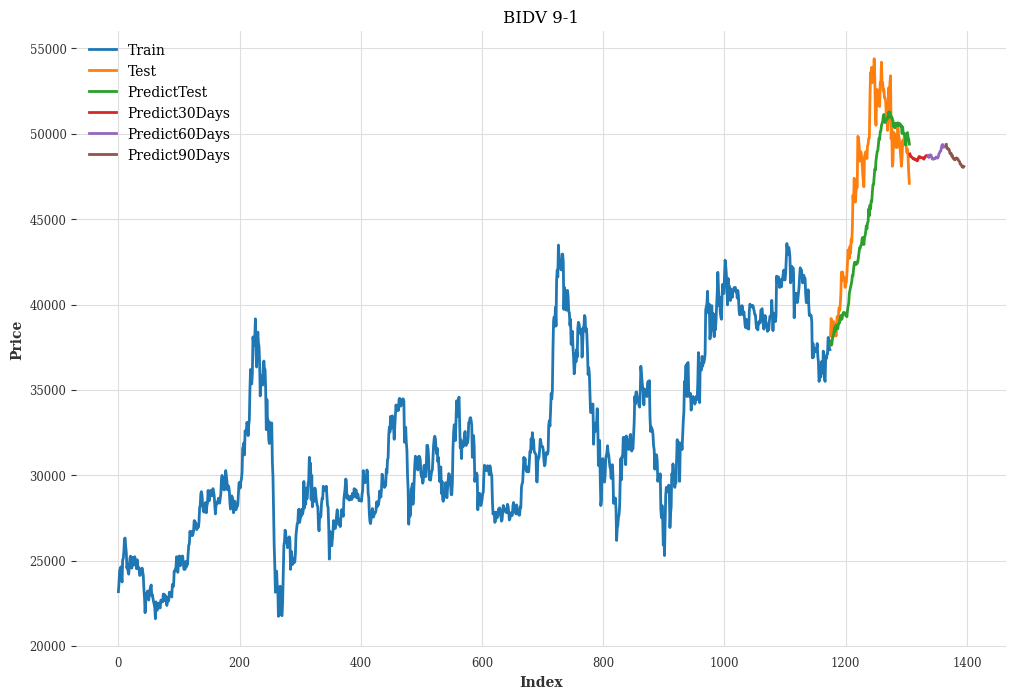

In [ ]:
data_train.plot(color=COLORS[0])
data_test.plot(color=COLORS[1])
pred_test.plot(color=COLORS[2])
pred_future[0:30].plot(color=COLORS[3])
pred_future[30:60].plot(color=COLORS[4])
pred_future[60:90].plot(color=COLORS[5])
figname = f'{DATASET_LABEL} {TRAIN_TEST_LABEL}'
plt.title(figname)
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend(['Train','Test','PredictTest','Predict30Days','Predict60Days','Predict90Days'])
plt.show()

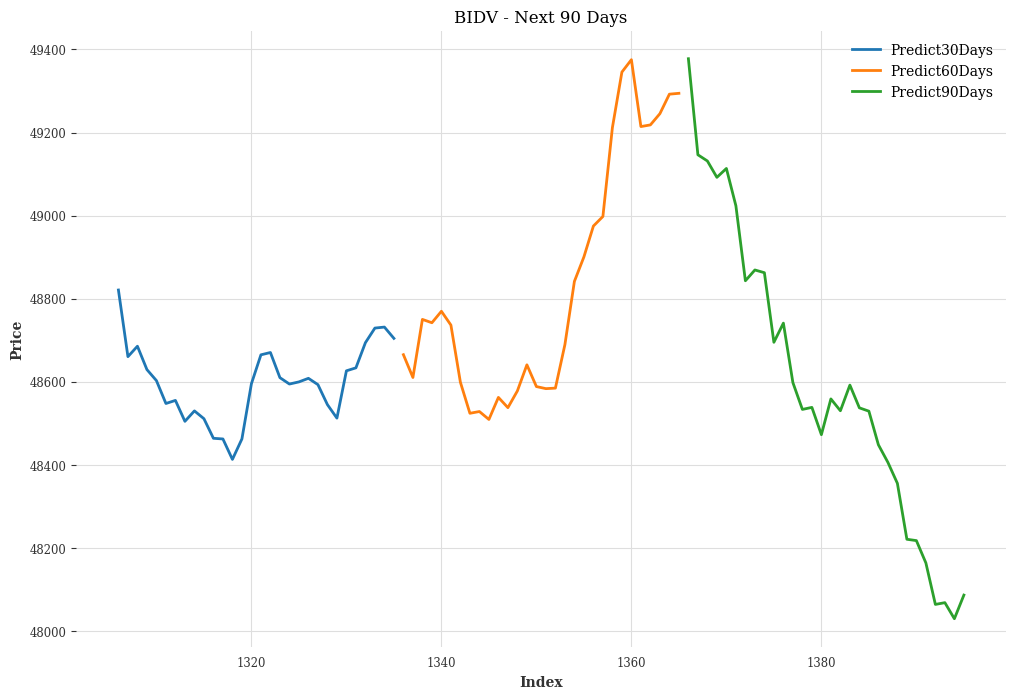

In [ ]:
pred_future[0:30].plot(color=COLORS[0])
pred_future[30:60].plot(color=COLORS[1])
pred_future[60:90].plot(color=COLORS[2])
day_label = 'Days' if DAY_TO_PREDICT > 1 else 'Day'
figname = f'{DATASET_LABEL} - Next {DAY_TO_PREDICT} {day_label}'
plt.title(figname)
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend(['Predict30Days','Predict60Days','Predict90Days'])
plt.show()

# Test

In [ ]:
pred_future_direct = scaler.inverse_transform(scaled_pred_future_direct)
pred_future_ims = scaler.inverse_transform(scaled_pred_future_ims)

In [ ]:
import yfinance as yf
from datetime import datetime

ticker_symbol = 'BID.VN'

start_date = '2024-06-01'
end_date = datetime.now().strftime('%Y-%m-%d')

bidv_data = yf.download(ticker_symbol, start=start_date, end=end_date)
bidv_close = bidv_data['Close']

[*********************100%%**********************]  1 of 1 completed


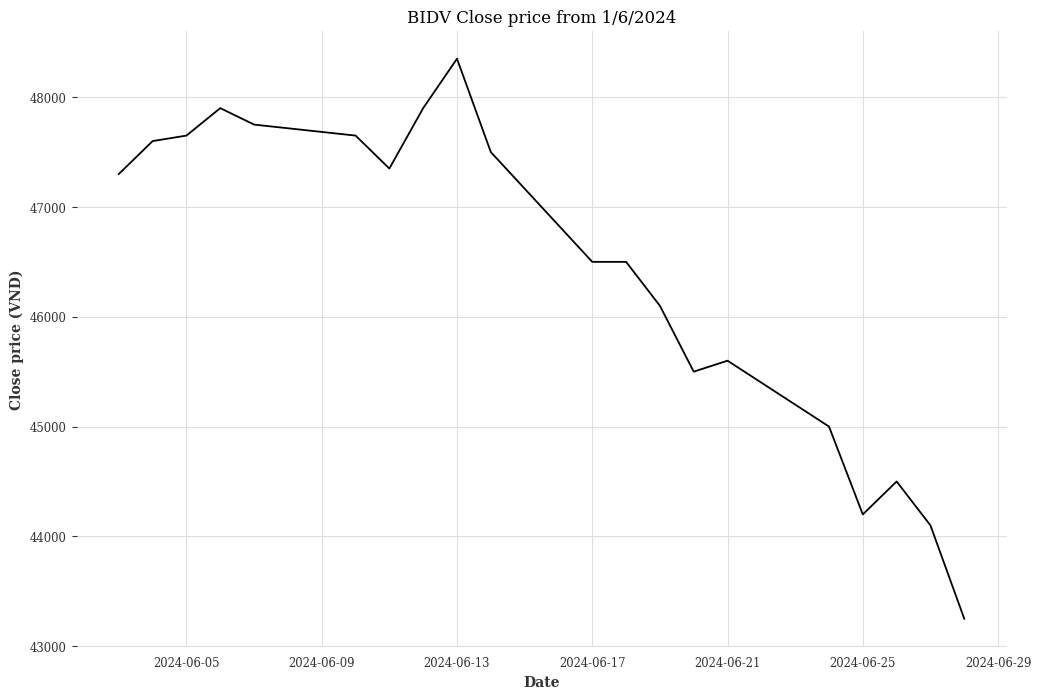

In [ ]:
plt.plot(bidv_close)
plt.title('BIDV Close price from 1/6/2024')
plt.xlabel('Date')
plt.ylabel('Close price (VND)')
plt.grid(True)
plt.show()

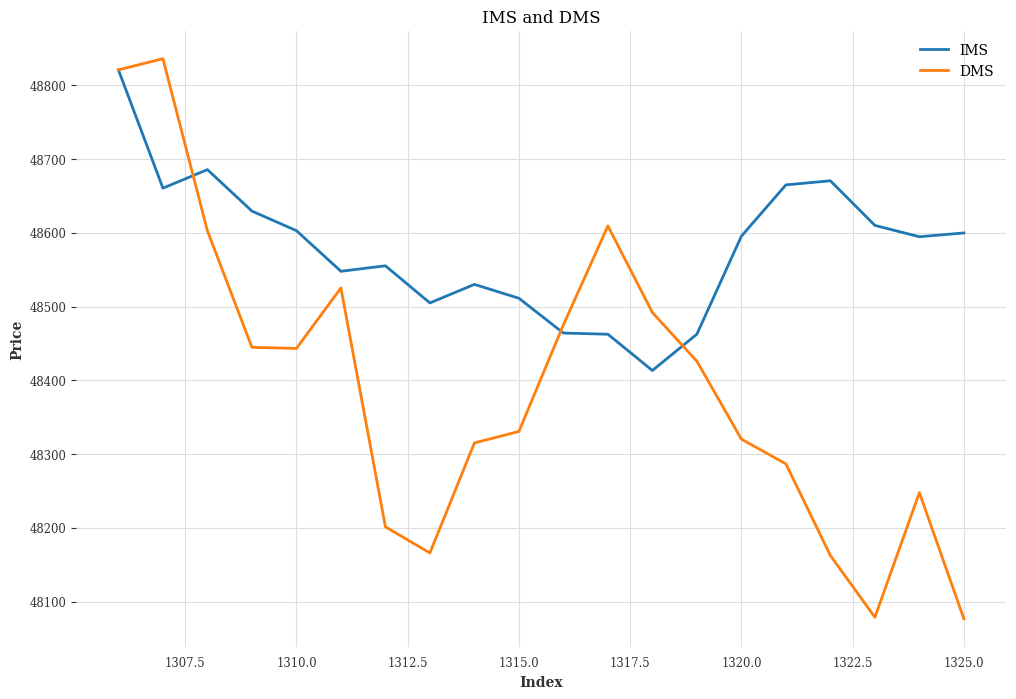

In [ ]:
pred_future_ims[0:len(bidv_close)].plot(color=COLORS[0])
pred_future_direct[0:len(bidv_close)].plot(color=COLORS[1])

figname = f'IMS and DMS'
plt.title(figname)
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend(['IMS','DMS'])
plt.show()